# `00` **Cats vs Dogs**
- Design my Deep Convolutional Neural Network using `Transfer Learning` (MobileNetV2)
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).


# `01` **Import librires**

In [20]:
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from PIL import Image
import gdown
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Dense, Conv2D, MaxPool2D, Flatten ,Activation, MaxPooling2D,  Input , GlobalAveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Rescaling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# `02` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   132M      0  0:00:05  0:00:05 --:--:--  127M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [6]:
# Delete Corrupted Images
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


# `03` Set Global Parameters

In [23]:
BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = (224, 224, 3)
SEED = 1234
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)


In [8]:
train = image_dataset_from_directory(
    "PetImages",
    subset="training",
    validation_split=0.15,
    seed=1234,
    image_size=(IMG_SIZE),
    batch_size=BATCH_SIZE,
)

val = image_dataset_from_directory(
    "PetImages",
    subset="validation",
    validation_split=0.15,
    seed=1234,
    image_size=(IMG_SIZE),
    batch_size=BATCH_SIZE,
)

Found 23410 files belonging to 2 classes.
Using 19899 files for training.
Found 23410 files belonging to 2 classes.
Using 3511 files for validation.


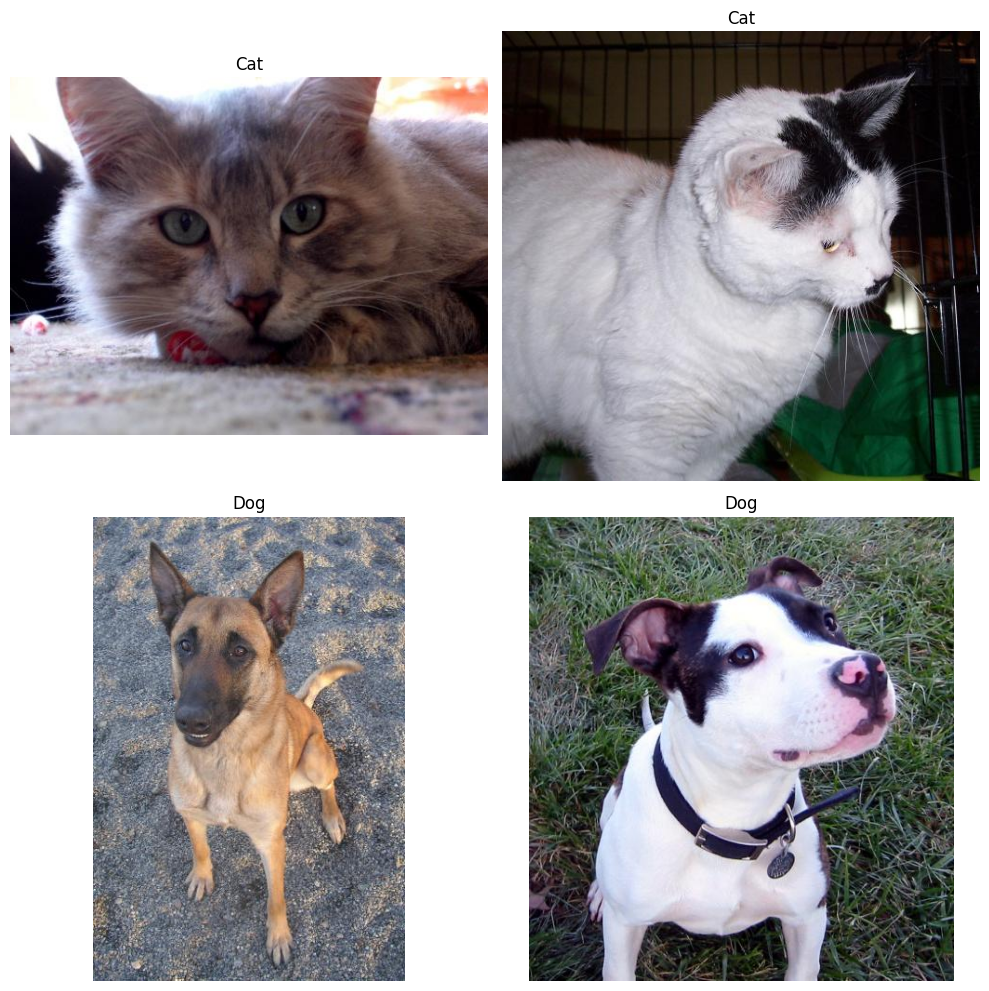

In [17]:
image_folder_cats = 'PetImages/Cat'
image_folder_dogs = 'PetImages/Dog'

cat_images = [os.path.join(image_folder_cats, f) for f in os.listdir(image_folder_cats)
              if os.path.isfile(os.path.join(image_folder_cats, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
dog_images = [os.path.join(image_folder_dogs, f) for f in os.listdir(image_folder_dogs)
              if os.path.isfile(os.path.join(image_folder_dogs, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

image_files = cat_images[7:9] + dog_images[1:3]
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_files):
    img = mpimg.imread(image_path)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    label = 'Cat' if 'Cat' in image_path else 'Dog'
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


# `04` Model Design

In [29]:
# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

# Rescaling
rescale = Sequential([
    Rescaling(1./255)
])

# Pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
augmented_ds = train.map(lambda x, y: (data_augmentation(x, training=True), y))
rescaled_ds = augmented_ds.map(lambda x, y: (rescale(x), y))

## Model Compilation & Training

In [31]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
history = model.fit(train,validation_data=val,epochs=EPOCHS,callbacks=[early_stop],verbose=1)

Epoch 1/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.6034 - loss: 0.6899 - val_accuracy: 0.7143 - val_loss: 0.5689
Epoch 2/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 65s 49ms/step - accuracy: 0.7073 - loss: 0.5686 - val_accuracy: 0.7271 - val_loss: 0.5381
Epoch 3/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 42s 51ms/step - accuracy: 0.7141 - loss: 0.5555 - val_accuracy: 0.7374 - val_loss: 0.5352
Epoch 4/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.7182 - loss: 0.5520 - val_accuracy: 0.7317 - val_loss: 0.5287
Epoch 5/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.7224 - loss: 0.5489 - val_accuracy: 0.7371 - val_loss: 0.5228
Epoch 6/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.7177 - loss: 0.5488 - val_accuracy: 0.7328 - val_loss: 0.5231
Epoch 7/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.7271 - loss: 0.5474 - val_accuracy: 0.7377 - val_loss: 0.5224
Epoch 8/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.7195 - loss: 0

##  Model Evaluation

In [33]:
loss, accuracy = model.evaluate(val)
print(f"Accuracy: {accuracy}")
print(f"Loss: {loss}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.7443 - loss: 0.5254
Accuracy: 0.7485046982765198
Loss: 0.5154430270195007


## Result Visualization

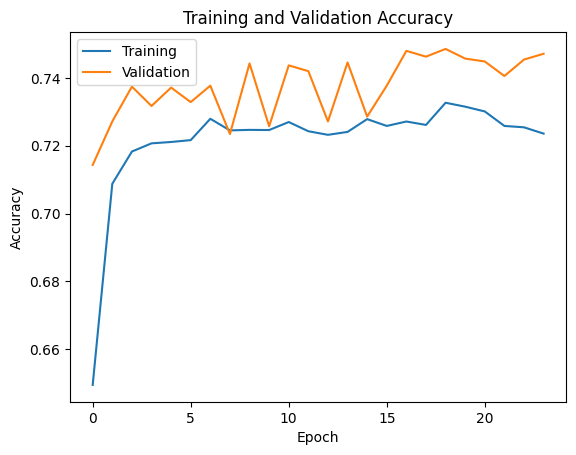

In [34]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

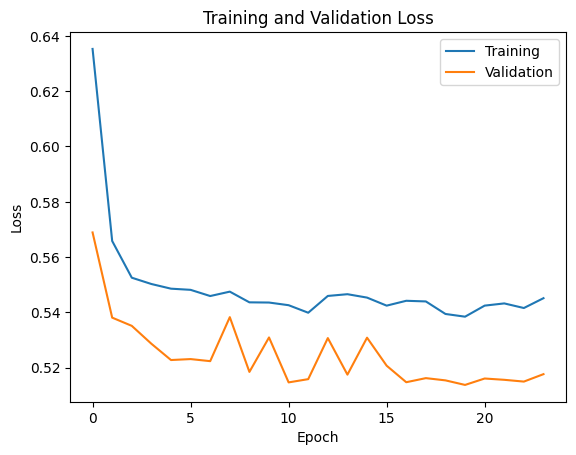

In [35]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## `05` Let's Test Our Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


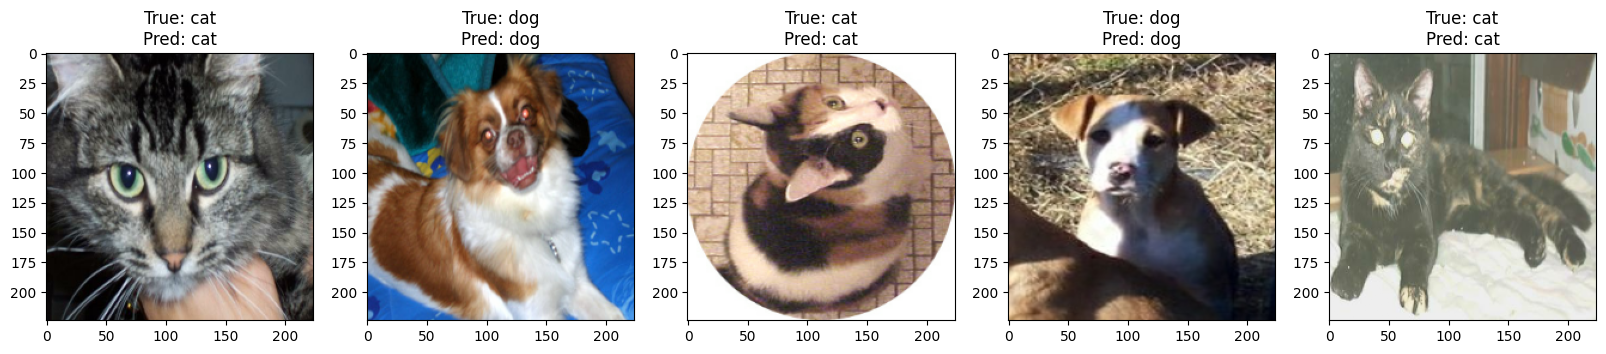

In [44]:
val_images, val_labels = next(iter(val))

# Select the 5 images from the batch
val_images = val_images[15:20]
val_labels = val_labels[15:20]
val_images = val_images / 255.0
predictions = model.predict(val_images)

# Convert predictions to binary labels (0 or 1)
predicted_labels = [int(round(pred[0])) for pred in predictions]
class_names = ['cat', 'dog']


plt.figure(figsize=(20, 8))
for i in range(len(val_images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(val_images[i])
    true_label = class_names[int(val_labels[i].numpy())]
    predicted_label = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
plt.show()


## photos from internet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


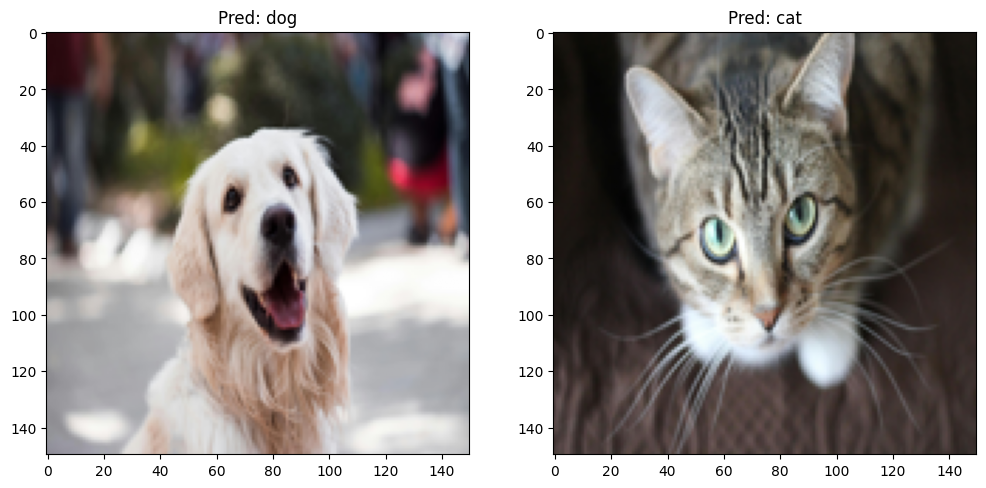

In [46]:
# Function to load an image from the internet
def load_image_from_url(url, target_size=(150, 150)):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    img = Image.open(response.raw)
    img = img.resize(target_size)
    img = np.array(img)
    img = img / 255.0
    return img

image_urls = [
    "https://images.pexels.com/photos/1490908/pexels-photo-1490908.jpeg",
    "https://images.pexels.com/photos/20787/pexels-photo.jpg?cs=srgb&dl=pexels-kmerriman-20787.jpg&fm=jpg"
]

images = [load_image_from_url(url) for url in image_urls]


images = np.array(images)

predictions = model.predict(images)

predicted_labels = [int(round(pred[0])) for pred in predictions]

class_names = ['dog', 'cat']

plt.figure(figsize=(12, 6))
for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(images[i])
    predicted_label = class_names[predicted_labels[i]]
    plt.title(f"Pred: {predicted_label}")
plt.show()
